In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u

from ctapipe.coordinates import CameraFrame

from ctapointing.config import (
    Config,
)

from ctapointing.camera import FlashCam, MAGICCam
from ctapointing.coordinates import SkyCameraFrame
from ctapointing.exposure import Exposure
from ctapointing.exposure.utils import plot_exposure, plot_spots, plot_coords
from ctapointing.imagesolver import SpotExtractor, LEDFitter

from ctapointing.exposure.exposure_simulator import ExposureSimulator

In [2]:
from skimage.draw import polygon

# not used yet
def get_cameraFrame(scienceCamera):
    return CameraFrame(
        focal_length=scienceCamera.focal_length,
        rotation=scienceCamera.rotation,
    )

# not used yet
def get_skyCameraFrame(exposure):
    return SkyCameraFrame(
        focal_length=exposure.camera.focal_length[0],
        rotation=exposure.camera.rotation,
        tilt_x=1.1*u.deg,
        tilt_y=1.22*u.deg,
    )

def rasterize_polygon(vertex_positions_2D):
    return polygon(vertex_positions_2D[:,0], vertex_positions_2D[:,1])

def simulate_mask(scienceCamera, exposure):
    # in coordinate system of the Cherencov camera
    camera_frame = CameraFrame(
        focal_length=scienceCamera.focal_length,
        rotation=scienceCamera.rotation,
    )
    # in coordinate system of the chip
    skycamera_frame = SkyCameraFrame(
        focal_length=exposure.camera.focal_length[0],
        rotation=exposure.camera.rotation,
        tilt_x=1.1*u.deg,
        tilt_y=1.22*u.deg,
    )

    # read from camera and transform to sky coordinates
    vertex_positions_sky = SkyCoord(
        scienceCamera.vertex_positions[:,0],
        scienceCamera.vertex_positions[:,1],
        frame=camera_frame
    )

    # transform to pixel coordinates
    vertex_positions_pix = vertex_positions_sky.transform_to(skycamera_frame)
    vertex_positions_pix = exposure.camera.transform_to_pixels(vertex_positions_pix)

    # rasterize the mask
    row, col = rasterize_polygon(vertex_positions_pix) # these are probably index positions -> see filled_rect[row, col] = 1

    mask = np.zeros(np.shape(exposure.image), dtype=exposure.image.dtype)
    mask[row, col] = 1 # does not work if the polygon has verticies outside of exposure.image
    
    return mask

def simulate_LEDs():
    pass


In [3]:
Config.read_config('test_MAGIC_MAGICmask_CvE')
Config.image_path = "/Users/mhein/ctapointing/images"
Config.mask_path = "/Users/mhein/ctapointing/ctapointing/data/masks"
Config.print()

Config:
  name=test_MAGIC_MAGICmask_CvE
  image_path=/Users/mhein/ctapointing/images
  mask_path=/Users/mhein/ctapointing/ctapointing/data/masks
  star_extractor_config_name=thresh_1.0_MAGICmask
  led_extractor_config_name=thresh_0.2_MAGICmask_LED
  solver_config_name=None



In [4]:
exposure = Exposure.from_name(name='8907c27d-1223-40fe-ac9f-32590df40ffa', collection='MAGIC-Campaign')
print(exposure)
exposure.camera.tilt = [1.1,1.22] * u.deg

Exposure:
  uuid:            8907c27d-1223-40fe-ac9f-32590df40ffa
  filename:        image_1559342132_with_uuid.fits.gz
  start time:      2019-05-31T22:35:32.914
  duration:        10.0 s
  pressure:        None
  chip temp:       1.8042255 deg_C
  camera temp:     None
  camera humidity: None
  camera config:   MAGIC-001-precalibrated
Exposure Pointing:
  telescope_pointing: None
  nominal_telescope_pointing: <SkyCoord (ICRS): (ra, dec) in deg
    (197.2625, -2.07305556)>



In [5]:
magiccam = MAGICCam()

In [6]:
# in coordinate system of the Cherenkov camera
camera_frame = CameraFrame(
    focal_length=magiccam.focal_length,
    rotation=magiccam.rotation,
)

# in coordinate system of the chip
skycamera_frame = SkyCameraFrame(
    focal_length=exposure.camera.focal_length[0],
    rotation=exposure.camera.rotation,
    tilt_x=1.1*u.deg,
    tilt_y=1.22*u.deg,
)

In [7]:
# in chrerenkov coord to sky coordinates
led_positions = magiccam.led_positions
led_positions

<SkyCoord (CameraFrame: focal_length=17.0 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None): (x, y) in m
    [(-6.30000000e-01,  0.00000000e+00),
     (-5.45596004e-01,  3.15000000e-01),
     (-3.15000000e-01,  5.45596004e-01),
     (-3.85763742e-17,  6.30000000e-01),
     ( 3.15000000e-01,  5.45596004e-01),
     ( 5.45596004e-01,  3.15000000e-01),
     ( 6.30000000e-01,  7.71527483e-17),
     ( 5.45596004e-01, -3.15000000e-01),
     ( 3.15000000e-01, -5.45596004e-01),
     ( 1.15729123e-16, -6.30000000e-01),
     (-3.15000000e-01, -5.45596004e-01),
     (-5.45596004e-01, -3.15000000e-01)]>

In [8]:
# transform to pixel coord of chip system
led_positions_pix = exposure.transform_to_camera(led_positions)
led_positions_pix = exposure.camera.transform_to_pixels(led_positions_pix)
led_positions_pix

<Quantity [[1757.03048042, 1844.86424541],
           [1710.84867356, 1673.10950489],
           [1585.00950592, 1547.43405252],
           [1413.28686026, 1501.48130313],
           [1241.68638419, 1547.505243  ],
           [1116.09168374, 1673.07795048],
           [1070.03241919, 1844.58337776],
           [1115.85715854, 2016.26172496],
           [1241.45165612, 2142.20823413],
           [1413.28686026, 2188.50857955],
           [1585.24456857, 2142.56091984],
           [1711.08377799, 2016.71700972]]>

In [9]:
led_extractor = SpotExtractor.from_name(Config.led_extractor_config_name)
led_extractor

SpotExtractor(uuid=22fb5cc3-b03b-4164-a993-0c2b5ee53282, name=thresh_0.2_MAGICmask_LED, detection_threshold=0.2, kernel_size=10, use_tophat_kernel=True), min_spot_distance=10.0

In [10]:
ledlist = led_extractor.process(exposure)
ledlist.data

<Table length=9>
 coord_x   coord_y    var_x     var_y   ...    flux       peak   Status
 float32   float32   float32   float32  ...  float32    float32  int64 
--------- --------- --------- --------- ... ---------- --------- ------
1237.3916 2142.1084 14.093895 14.125781 ...  183383.81 1638.0576      0
 1703.967 1671.0214 13.761627 13.333492 ...  143676.52 1279.0715      0
1751.0171 1842.7756 13.021147 12.844133 ... 122598.266 1150.3458      0
1580.5486 2140.3726 11.220727 11.294348 ...   93608.09  977.8778      0
  1110.99 2017.4685 11.243197 11.106289 ...   88840.63  901.9839      0
1108.3927  1674.415 10.247159 10.064879 ...   67181.64  701.3734      0
1404.8875 1501.2451 7.8482094  7.796875 ...  43660.668  560.2064      0
1253.0612 2222.0684 6.3367357 6.3403006 ...  56112.703 716.79767      0
1233.2043 1548.5781 6.7306275 6.0297184 ...   32367.96  483.4646      0

In [11]:
led_fitter = LEDFitter()

# prefit (for demonstration only)
coords = np.array((ledlist["coord_x"], ledlist["coord_y"])).T
(cx_pre, cy_pre), r_pre, _ = led_fitter.circlefit(coords)

# full fit (including circle prefit)
(cx, cy), r, rot, used_coords = led_fitter.process(ledlist)

print(f"cx: {cx} cy: {cy} r: {r} rot: {rot}")
print(f"used coords:\n {used_coords}")

cx: 1407.1688951782673 cy: 1844.3596262948158 r: 343.30201269366785 rot: -0.34162624058985663
used coords:
 [[1237.3916 2142.1084]
 [1703.967  1671.0214]
 [1751.0171 1842.7756]
 [1580.5486 2140.3726]
 [1110.99   2017.4685]
 [1108.3927 1674.415 ]
 [1404.8875 1501.2451]
 [1233.2043 1548.5781]]


In [12]:
### Martin: repeat steps for vertex_postions, without extracting

# read from MAGICcam (camera coordinates) and transform to sky coordinates 
vertex_positions = magiccam.body_vertex_positions
vertex_positions

<SkyCoord (CameraFrame: focal_length=17.0 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None): (x, y) in m
    [(-1.15, -1.), ( 1.15, -1.), ( 1.15,  1.), (-1.15,  1.)]>

In [13]:
# transform to pixel coordinates
vertex_positions_pix = exposure.transform_to_camera(vertex_positions)
vertex_positions_pix = exposure.camera.transform_to_pixels(vertex_positions_pix)
vertex_positions_pix

<Quantity [[2043.67909942, 2392.01979266],
           [ 784.53787712, 2390.07903806],
           [ 786.11096579, 1300.22000761],
           [2042.09778772, 1299.31465673]]>

In [14]:
def print_unique_infos(array, __name):
    print(f"\nshape of {__name}:", array.shape)
    unique = np.unique(array)
    print(f"unique values in {__name}:", unique)
    unique_dict = {}
    for i in unique:
        unique_dict[i] = np.count_nonzero(array == i)
    print(unique_dict)

In [15]:
from ctapointing.camera import ApogeeAspen8050Camera
expSim = ExposureSimulator()
simExposure = expSim.process()
cameraBody = expSim.simulate_sciencecamera(magiccam)
# (magiccam, exposure, camera_frame, skycamera_frame)
# fig, axis = plt.subplots(ncols=2)
# axis[0].imshow(bodyShape, cmap='Blues')


# pointingCamera = ApogeeAspen8050Camera()
# leds = expSim.simulate_LEDs(magiccam, pointingCamera, exposure, camera_frame, skycamera_frame)

# fig, axis = plt.subplots(figsize=(80,80))
# axis.imshow(leds, cmap="Reds", origin="lower")
# # axis.plot(led_positions_pix, marker="circle")
# plot_coords(led_positions_pix, ax=axis, label=f"nominal LED positions ({len(led_positions_pix)})",
#             marker="o", color="cyan")
# print(bodyShape)

TypeError: process() missing 4 required positional arguments: 'camera', 'telescope_pointing', 'start_time', and 'duration'

In [ ]:
### Test gaussian profile for one led

leds = expSim.simulate_LEDs(magiccam, exposure, camera_frame, skycamera_frame)
led_positions_pix = transform_scienceCamera_to_exposurePixels(
    magiccam.led_positions, 
    camera_frame, 
    skycamera_frame, 
    exposure
)
# below

In [ ]:
from scipy.optimize import curve_fit

def slice_rows(image, row, add_width, mean=False):
    
    if add_width == 0:
        return image[row]
    
    sliced_row = np.zeros(image.shape[1])
    for r in range(row - add_width, row + add_width, 1):
        sliced_row += image[r]

    if mean: # TODO: not working
        sliced_row /= (2*add_width + 1)

    return sliced_row

def slice_ledImage(image, select_led, led_positions_pix, add_width, mean=False):
    print(led_positions_pix.shape)

    slice_row = led_positions_pix[select_led][0].astype(int)
    
    print(leds.shape)
    print(leds[slice_row].shape)
    
    return slice_rows(image, slice_row, add_width, mean=mean)


select_led = 0
led_slice = slice_ledImage(leds, select_led, led_positions_pix, 5)
single_slice = slice_ledImage(leds, select_led, led_positions_pix, 0)

range_ = (1835, 1855)
y = led_slice[range_[0]:range_[1]]
y_s = single_slice[range_[0]:range_[1]]
x = range(range_[0], range_[1])

# make gaussian fit
# compare width sigma [pix] with original radius [meters]

def gaussian(x, mu, sigma, scale):
    return scale / np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * ((x - mu) / sigma)**2 )

m = led_positions_pix[select_led][0]
s = 0.2 # 2.7250318529031574 -> transforming two points with distance of <radius> m and get distance
# transform_scienceCamera_to_exposurePixels(magiccam.led_radius, camera_frame, skycamera_frame, exposure)
a = 60000 #magiccam.led_intensity[select_led] / 1000

p0 = [m, s, a]
popt, pcov = curve_fit(gaussian, x, y, p0=p0)
p_err = np.sqrt(np.diag(pcov))

print("p0: \t mu: {} pix, sigma: {} pix, scale: {} pix".format(*popt))
print("popt: \t mu: {} pix, sigma: {} pix, scale: {} pix".format(*popt))
print("pcov:\n", pcov)
print("p_err:", p_err, "[pix]")

plt.plot(x, y_s, "r+")
plt.plot(x, y, "kx")
plt.plot(x, gaussian(x, *popt),"--", color="orange")
plt.show()

# plt.show()

NameError: name 'leds' is not defined

In [ ]:
for i in range(1,5, 3):
    print("i")

i
i


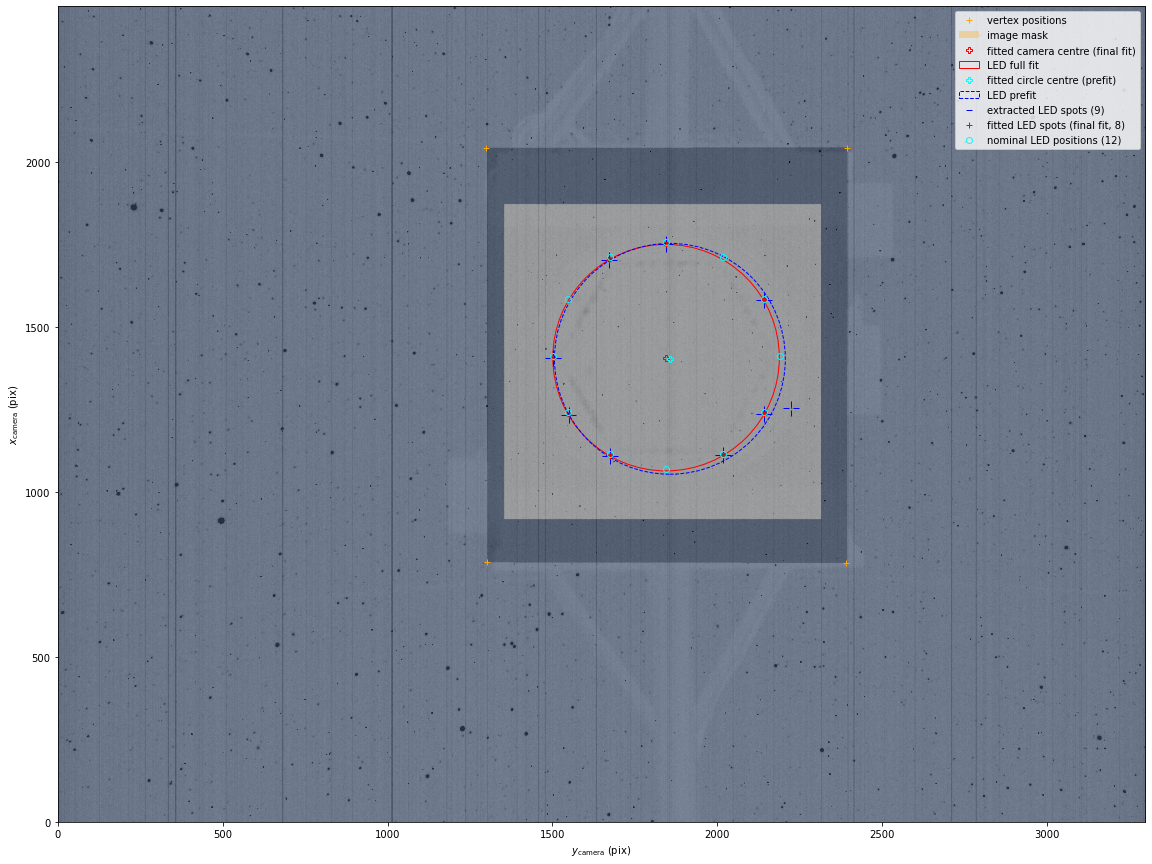

In [ ]:
im = plot_exposure(exposure)
ax = im.axes

#** plot shaded area of rectangular / polygonial mask and the edge positions

ax.imshow(bodyShape, alpha=0.2, origin='lower', cmap='Greys')
plot_coords(vertex_positions_pix, ax=ax, label=f'vertex positions', marker='+', color='orange')
#**

# plot old mask - no longer neccassary?
ax.imshow(led_extractor.image_mask.image, alpha=0.3, origin='lower', cmap='Blues')
_fakebox = plt.Rectangle((0.0, 0.0), 0.0, 0.0, fc='orange', alpha=0.3, label='image mask')
ax.add_patch(_fakebox)    

# fitted circle
if r is not None:
    led_centre = np.array([cx, cy]).reshape(1,2)
    plot_coords(led_centre, ax=ax, label="fitted camera centre (final fit)", marker="P", color="red")
    led_circle = plt.Circle((cy, cx), r, color='r', linestyle='-', fill=False, label="LED full fit")
    ax.add_patch(led_circle)

# prefit circle
if r_pre is not None:
    circle_centre = np.array([cx_pre, cy_pre]).reshape(1,2)
    led_circle_pre = plt.Circle((cy_pre, cx_pre), r_pre, color='b', linestyle='--', fill=False, label="LED prefit")
    plot_coords(circle_centre, ax=ax, label="fitted circle centre (prefit)", marker="P", color="cyan")
    ax.add_patch(led_circle_pre)

# plot extracted LED spots
plot_spots(ledlist, ax=ax, label=f'extracted LED spots ({len(ledlist)})', color='blue')

if used_coords is not None:
    plot_coords(used_coords, ax=ax, label=f'fitted LED spots (final fit, {len(used_coords)})', marker='+', color='red')

# plot nominal LED spots (from class MAGICCam)
plot_coords(led_positions_pix, ax=ax, label=f"nominal LED positions ({len(led_positions_pix)})",
            marker="o", color="cyan")


# leds_on_exposure = np.zeros(np.shape(exposure.image), dtype=exposure.image.dtype)
# leds_on_exposure[led_positions_pix[:0].astype(int), led_positions_pix[:1].astype(int)] = 1
# ax.imshow(leds_on_exposure, cmap="Greens")

ax.legend(loc='upper right')
# im.figure.savefig('DemoLEDFitting.pdf')

plt.show()

In [ ]:
led_positions_pix = transform_scienceCamera_to_exposurePixels(
    magiccam.led_positions, 
    camera_frame, 
    skycamera_frame, 
    exposure
)


In [ ]:
np.random.exponential((1 * u.m).to_value(u.m))

0.04789632017650231

In [ ]:
n_leds = len(magiccam.led_positions)
radius = 5e-3 * u.m # magiccam.led_radius # in meters
smearing_rays = 1000

# r_smear = np.arctan(
#     siminfo.smearing_radius * camera.pixel_size / camera.focal_length[0]
# ).to("arcsec")
# log.info(
#     "smearing star positions by Gaussian of width {:.0f}".format(r_smear)
# )

# use 2D Gaussian (polar coordinates) as smearing kernel
# these are already values from gaussian function
# for polar coordinates radius and angle
radial_offset = (
    np.sqrt(
        np.random.exponential(
            radius.to_value(u.m) ** 2,
            size=(smearing_rays, n_leds), 
            # size = (anzahl der zufälligen punkte für gauß, #LEDS)
        )
    )
    * u.m
)
position_angle = (
    np.random.random(size=(smearing_rays, n_leds))
    * 360
    * u.deg
)

In [ ]:
"""
Improvements:
 - change axes from beginning, so no swapping axes will be needed
 - "parallelize" transformation for all rays in some form of numpy operation
"""

# print(radial_offset.value)
print("radial offset shape:", radial_offset.shape)


# polar to cartesian coords
x_coords = radial_offset * np.cos(position_angle) # (1000, 12)
y_coords = radial_offset * np.sin(position_angle)
# print(x_coords)
# not really uesd except for creating coords_pix # (2, 1000, 12)
coords_smeared = np.array([y_coords, x_coords])
# print(y_coords[0])
# print(x_coords[0])
print("y coordinates shape:", y_coords.shape)
print("smeared coords shape:", coords_smeared.shape)
# print(coords_smeared)

# shape: coords_smeared = [ y[rays[leds]], x[rays[leds]] ]

print("\nconvert to pixel coords...")
coords_pix = np.zeros(coords_smeared.shape) # shape (2, 1000, 12)
# print("shape of coords_pix", coords_pix.shape)

## calculate for each ray individually
for ray in range(smearing_rays):
    coords_per_ray = np.array([y_coords[ray], x_coords[ray]]) * u.m # (2, 12)
    # print(coords_per_ray.shape)
    # print(coords_per_ray)

    ## need shape (12, 2) for transormation, (2, 12) given -> swapaxes
    swaped = np.swapaxes(coords_per_ray, 0,1) # (12, 2)
    # print("swaped:")
    # print(swaped.shape)
    # print(swaped)
    
    # add the position distribution to the led positions
    swaped += magiccam.led_positions

    coords_pix_per_ray = transform_scienceCamera_to_exposurePixels(swaped, camera_frame, skycamera_frame, exposure)
    # back to shape (2, 12)
    coords_pix_per_ray = np.swapaxes(coords_pix_per_ray, 0,1) # (2, 12)

    # print(coords_per_ray.shape)
    # print(coords_per_ray)
    # print(coords_pix_per_ray.shape)
    # print(coords_pix_per_ray)

    # write pixel coordinates to array by same shape as before
    coords_pix[0][ray] = coords_pix_per_ray[0]
    coords_pix[1][ray] = coords_pix_per_ray[1]

print("done...")


radial offset shape: (1000, 12)
y coordinates shape: (1000, 12)
smeared coords shape: (2, 1000, 12)

convert to pixel coords...
done...


In [ ]:



# if you run the following, you will see, that many coordinates get 
# rounded to the same values due to integer pixel positions
if 0:
    print_unique_infos(coords_pix[0], "coords_pix[0]")
    print_unique_infos(coords_pix[1], "coords_pix[1]")


### create a image array like exposure.image and insert the distributed 
### intensities to the calculated pixel coordinates
leds_on_exposure = np.zeros(np.shape(exposure.image), dtype=exposure.image.dtype)

distributed_intensity = magiccam.led_intensity / smearing_rays
distributed_intensity = np.tile(distributed_intensity, smearing_rays)

cpix = coords_pix.swapaxes(0,2).reshape((-1,2))

nx, ny = exposure.camera.num_pix
image, _ = np.histogramdd(
    cpix,
    bins=(nx, ny),
    weights=distributed_intensity,
    range=((-0.5, nx - 0.5), (-0.5, ny - 0.5)),
)

print("cpix:", cpix.shape)

print("distribution_intensity:", distributed_intensity.shape)
for i in range(50):
    print(distributed_intensity[i], end=" ")
print("\n")

p = 1
i=0
printy = False
# again for each ray seperately
for ray in range(smearing_rays):
    for idx in range(n_leds):

        y = coords_pix[0][ray][idx]
        x = coords_pix[1][ray][idx]

        if printy:
            print(f"ray: {ray}, led: {idx}")
            # print(y.shape)
            print("\t", y, "\t", x)

        # the intensity is homogeneously distributed among all rays, 
        # but the position distribution is of gaussian form
        distributed_intensity = magiccam.led_intensity[idx] / smearing_rays
        if p:
            print("in loop:", distributed_intensity.shape, "for each led -> (12,) && for each ray -> (12000,)")
            p=0

        if i < 50:
            print(distributed_intensity, end=" ")
            i+=1

        # distributed_intensity = np.tile(distributed_intensity, smearing_rays)

        ## set intensities to rounded pixel coordinates
        leds_on_exposure[y.astype(int)][x.astype(int)] += distributed_intensity

    if printy:
        print(" ")




## count the unique numbers of that image and print them
leds = expSim.simulate_LEDs(magiccam, exposure, camera_frame, skycamera_frame)
print_unique_infos(leds, "leds")
print_unique_infos(leds_on_exposure, "leds_on_exposure")
print_unique_infos(image, "histogramdd")


cpix: (12000, 2)
distribution_intensity: (12000,)
60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 

in loop: () for each led -> (12,) && for each ray -> (12000,)
60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 60.0 
shape of leds: (2472, 3296)
unique values in leds: [   0.   60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.
  720.  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380.
 1440. 1500. 1560. 1620. 1680. 1740. 1800. 1860. 1920. 1980. 2040. 2100.
 2160. 2220. 2280. 2340. 2400. 2460. 2520. 2580. 2640. 2700. 2760. 2820.
 2940.]
{0.0: 8146466, 60.0: 301, 120.0: 1

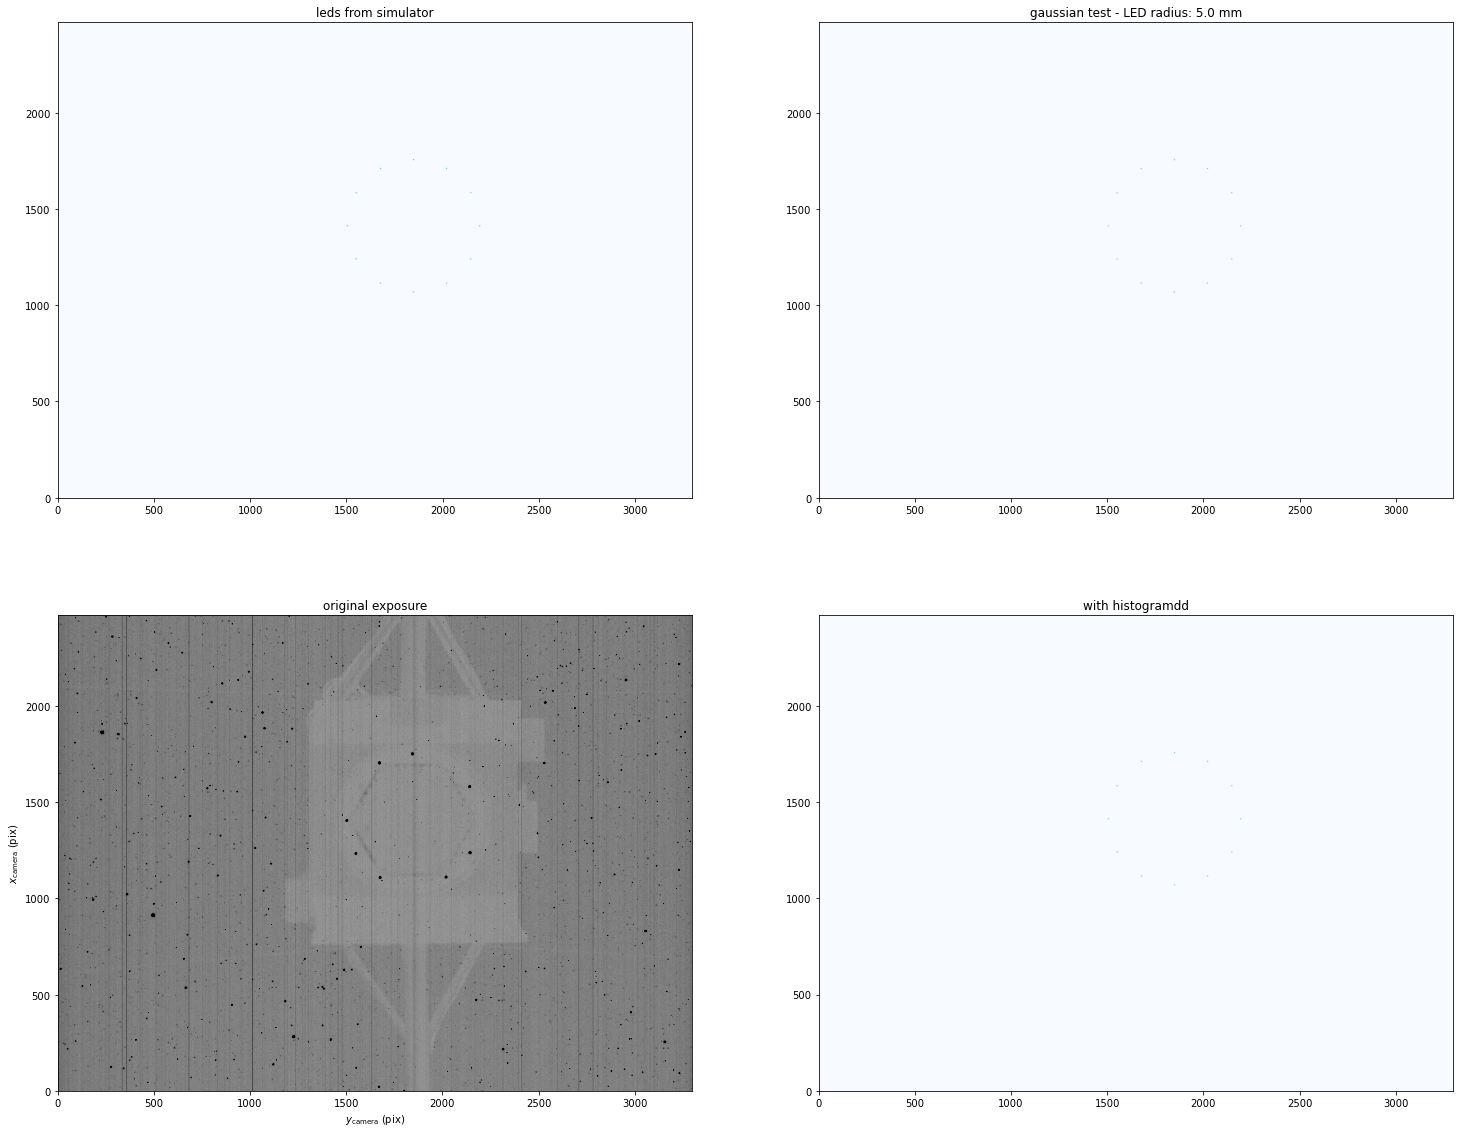

In [ ]:

# body = expSim.simulate_cameraBody(magiccam, exposure)
# overdrawnExposure = deepcopy(exposure)
# expSim.draw_cameraBody_over_exposure(body, overdrawnExposure)
# print("Check copy by ID:", id(exposure), id(overdrawnExposure), f"-> different instances? {not (id(exposure) == id(overdrawnExposure))}")



# print(body)
# print(overdrawnExposure)

# print("unique values in body:", np.unique(body))
# print("unique values in leds:", np.unique(leds))

# print("unique values in exposure:", "count:", len(np.unique(exposure.image)), "\n", np.unique(exposure.image))
# print("unique values in exposure + camera body:", "count:", len(np.unique(overdrawnExposure.image)), "\n", np.unique(overdrawnExposure.image))

# print(20*20 *12)
fig, axis = plt.subplots(figsize=(25,20), ncols=2, nrows=2)

axis[0][0].imshow(leds, cmap='Blues', origin="lower")
axis[0][1].imshow(leds_on_exposure, cmap='Blues', origin="lower")
# axis[0].set_title("with threshold == 0")
axis[0][0].set_title("leds from simulator")
axis[0][1].set_title(f"gaussian test - LED radius: {radius.value * 1e3} mm")


plot_exposure(exposure, ax = axis[1][0])
# plot_exposure(overdrawnExposure, ax = axis[1][1])

axis[1][1].imshow(image, cmap="Blues", origin="lower")

axis[1][0].set_title("original exposure")
axis[1][1].set_title("with histogramdd")


plt.show()

# fig.savefig("threshold.pdf")
# fig.savefig("comparison.pdf")


In [ ]:
print(image.dtype)

a = np.array([[2,1],[3,2],[4.5, 4]])
print(a.shape)

print(type(np.array((2,3))))
print(type([]))

print(np.max((2,)))

float64
(3, 2)
<class 'numpy.ndarray'>
<class 'list'>
2


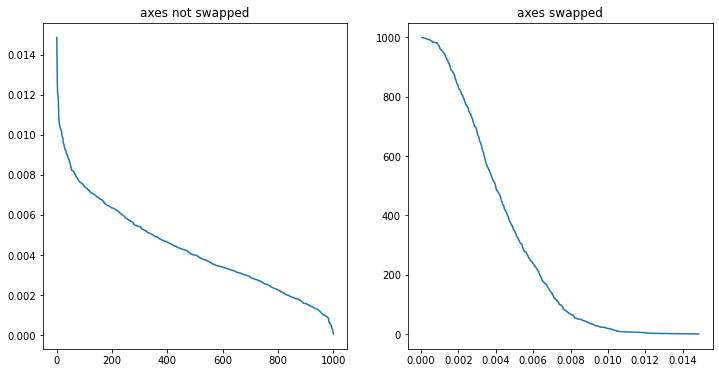

8.662140033770363 m
norm sum? 27.867342679910553


In [ ]:
r = np.flip(np.sort(radial_offset[:,1]))
x = np.linspace(0, len(r), len(r))

figi, axi = plt.subplots(figsize=(12,6), ncols = 2)
axi[0].plot(x, r)
axi[1].plot(r, x)

axi[0].set_title("axes not swapped")
axi[1].set_title("axes swapped")

plt.show()

print(2 * np.sum(r))

def normalize_vector(vector):
    return vector / np.sqrt(np.sum(vector**2))

rr = normalize_vector(r)
# print(rr)
print("norm sum?", sum(rr))

nx, ny = exposure.camera.num_pix
image, _ = np.histogramdd(
    coords_pix[:,:,1].swapaxes(0,1),
    bins=(nx, ny),
    weights=radial_offset[:,1],
    range=((-0.5, nx - 0.5), (-0.5, ny - 0.5)),
)

# plt.imshow(image, cmap='Blues', origin="lower")
# plt.show()

In [ ]:
r = 5e-3
c = np.array(
    [
        [0, 0],
        [r, 0],
        [0, r]
    ]
) * u.m

c_pix = transform_scienceCamera_to_exposurePixels(c, camera_frame, skycamera_frame, exposure)

print(c_pix)
print(c_pix[0][0] - c_pix[1][0])
print(c_pix[0][1] - c_pix[2][1])
print(exposure.image.dtype)

[[1413.28686026 1844.72371159]
 [1410.56194229 1844.72259755]
 [1413.28686026 1841.99867973]]
2.724917966425437
2.7250318529031574
uint16


0.0014545666578175077
[5, 5]


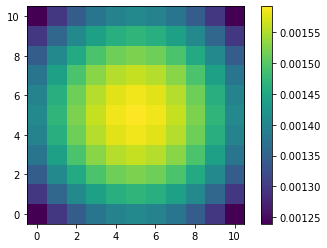

0.0014545666578175077
[10, 10]


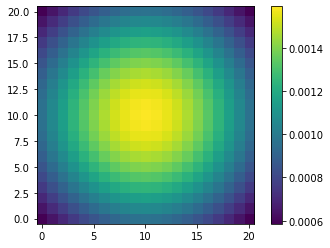

1.590117680815316e-05
[10, 10]


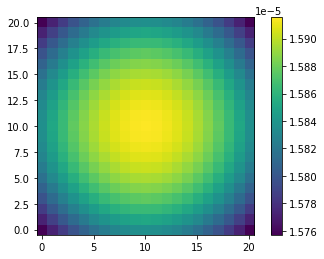

0.0014545666578175077
[40, 40]


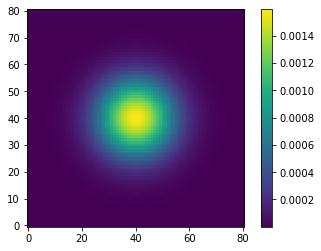

In [ ]:
from astropy.convolution import Gaussian2DKernel

# apply gaussian kernel in pixel coords to image
# determine gaussian kernel through led parameters in meter tranformed to pixel

smearing_radius = 1 * u.m # in science camera coordinates in meter
peak_intensity = 2e16 - 1

gaussianKernel = Gaussian2DKernel(smearing_radius.value)

# fig,ax = plt.subplots(nrows=4)
xsd = 10
sz = 11
gk = Gaussian2DKernel(xsd, x_size=sz, y_size=sz)
# print(gk.shape)
# print(gk.array)
off = 3
print(gk.array[gk.center[0]+off][gk.center[1]+off])
print(gk.center)
plt.imshow(gk, interpolation="none", origin="lower")
plt.colorbar()
plt.show()


sz = 21
gk = Gaussian2DKernel(xsd, x_size=sz, y_size=sz)
# print(gk.shape)
# print(gk.array)
print(gk.array[gk.center[0]+off][gk.center[1]+off])
print(gk.center)
plt.imshow(gk, interpolation="none", origin="lower")
plt.colorbar()
plt.show()

sz = 21
gk = Gaussian2DKernel(xsd*10, x_size=sz, y_size=sz)
# print(gk.shape)
# print(gk.array)
print(gk.array[gk.center[0]+off][gk.center[1]+off])
print(gk.center)
plt.imshow(gk, interpolation="none", origin="lower")
plt.colorbar()
plt.show()


gk = Gaussian2DKernel(xsd)#, x_size=sz, y_size=sz)
# print(gk.shape)
# print(gk.array)
print(gk.array[gk.center[0]+off][gk.center[1]+off])
print(gk.center)
plt.imshow(gk, interpolation="none", origin="lower")

plt.colorbar()

plt.show()